In [1]:
!pip install spmf

In [2]:
!pip install --quiet git+https://github.com/EgorDudyrev/paspailleur.git
import caspailleur as csp
from paspailleur import pattern_structures as PS

In [3]:
from importlib import reload

In [4]:
from script import clustering as clib, visual_lib as vlib
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from functools import reduce
from bitarray import frozenbitarray

# Test example of AprioriRare via SPMF

rare_itemsets_input.txt is taken from https://www.philippe-fournier-viger.com/spmf/AprioriInverse.php example

In [6]:
!java -jar ../script/spmf.jar run AprioriRare rare_itemsets_input.basenum rare_output.txt 50%

>/Users/egordudyrev/Documents/1. Projects/StablePatternClustering project/Paper_StablePatternClustering/script/spmf.jar
=============  APRIORI-RARE - STATS =============
 Candidates count : 14
 The algorithm stopped at size 4, because there is no candidate
 Minimal rare itemsets count : 3
 Maximum memory usage : 10.457344055175781 mb
 Total time ~ 6 ms


In [7]:
!rm rare_output.txt rare_output.pkl rare_output.csv
from spmf import Spmf

spmf = Spmf(
    "AprioriRare", input_filename="rare_itemsets_input.basenum",
    output_filename="rare_output.txt", arguments=['50%'],
    spmf_bin_location_dir='../script/'
)
spmf.run()

#print(spmf.to_pandas_dataframe(pickle=True))
#spmf.to_csv("rare_output.csv")

rm: rare_output.pkl: No such file or directory
rm: rare_output.csv: No such file or directory
>/Users/egordudyrev/Documents/1. Projects/StablePatternClustering project/Paper_StablePatternClustering/script/spmf.jar
=============  APRIORI-RARE - STATS =============
 Candidates count : 14
 The algorithm stopped at size 4, because there is no candidate
 Minimal rare itemsets count : 3
 Maximum memory usage : 10.457344055175781 mb
 Total time ~ 7 ms



In [8]:
!cat rare_output.txt

4 #SUP: 1
1 2 3  #SUP: 2
1 3 5  #SUP: 2


In [9]:
with open('rare_itemsets_input.basenum', 'r') as file:
    itemsets = [set(map(int,line.strip().split(' '))) for line in file.readlines()]
attr_extents = csp.io.transpose_context(csp.to_bitarrays(itemsets)[0])

In [10]:
clib = reload(clib)

print(list(clib.mine_rare_itemsets(attr_extents, int(len(itemsets)/2))))

[(3,)]


In [11]:
%timeit list(clib.mine_rare_itemsets(attr_extents, 2))

21.2 µs ± 53.9 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Test examples on Circles data

In [12]:
from sklearn import datasets

n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
X, y = noisy_circles

In [13]:
linscale_x = np.linspace(X[:,0].min(), X[:,0].max(), 11)
linscale_y = np.linspace(X[:,1].min(), X[:,1].max(), 11)
ps = PS.CartesianPS([PS.IntervalPS(values=linscale_x), PS.IntervalPS(values=linscale_y)])

In [14]:
min_support = 0.01
max_support = 0.8
min_delta_stability = 0.01

In [15]:
data = list(ps.preprocess_data(X))
attributes, attr_extents = zip(*ps.iter_attributes(data, min_support=min_support))
print(len(attributes))

38


In [16]:
%%time
stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_gsofia(
    attr_extents,
    n_objects=len(data), min_delta_stability=min_delta_stability, min_supp=min_support,
    use_tqdm=True, n_attributes=len(attributes)
)
stable_extents = sorted(stable_extents, key=lambda ext: ext.count(), reverse=True)
print(f"n extents", len(stable_extents))

  0%|          | 0/38 [00:00<?, ?it/s]

n extents 1729
CPU times: user 38.9 ms, sys: 7.7 ms, total: 46.6 ms
Wall time: 46 ms


In [17]:
from bitarray.util import count_and, count_or

jaccard_thold = 0.1
sparse_extents = []
for i, extent in enumerate(stable_extents):
    not_like_others = all(count_and(extent, other)/count_or(extent, other) <= jaccard_thold
                          for other in sparse_extents)
    if not_like_others:
        sparse_extents.append(extent)
print(len(stable_extents), len(sparse_extents))

1729 15


In [18]:
anticoncepts_bas = [~ba for ba in csp.io.transpose_context(sparse_extents)]
anticoncepts_itemsets = [{i+1 for i in iset} for iset in csp.to_itemsets(anticoncepts_bas)[0]]

In [19]:
with open('anticoncepts_circles.basenum', 'w') as file:
    txt = '\n'.join([
        ' '.join(map(str, itemset)) if itemset else ''
        for itemset in anticoncepts_itemsets
    ])
    file.write(txt)

In [20]:
%%time
from spmf import Spmf

spmf = Spmf(
    "AprioriRare", input_filename="anticoncepts_circles.basenum",
    output_filename="clusterings_circles.txt", arguments=['80%'],
    spmf_bin_location_dir='../script/'
)
spmf.run()

#print(spmf.to_pandas_dataframe(pickle=True))
#spmf.to_csv("clusterings_circles.csv")

>/Users/egordudyrev/Documents/1. Projects/StablePatternClustering project/Paper_StablePatternClustering/script/spmf.jar
=============  APRIORI-RARE - STATS =============
 Candidates count : 590
 The algorithm stopped at size 6, because there is no candidate
 Minimal rare itemsets count : 274
 Maximum memory usage : 10.937416076660156 mb
 Total time ~ 26 ms

CPU times: user 789 µs, sys: 5.26 ms, total: 6.05 ms
Wall time: 151 ms


In [21]:
with open('clusterings_circles.txt', 'r') as file:
    lines = list(map(str.strip, file.readlines()))
    clusterings, supports = zip(*map(lambda x: str.split(x, '#SUP:'), lines))
    #clusterings = [frozenset(map(int, line.strip().split(' '))) for line in clusterings]
    clusterings = [frozenset([int(x)-1 for x in line.strip().split(' ')]) for line in clusterings]
    supports = [int(line.strip()) for line in supports]
print(len(clusterings), len(supports))

274 274


In [22]:
anticoncepts_extents = [~ext for ext in sparse_extents]
print(len(anticoncepts_extents))

15


In [23]:
clib = reload(clib)

In [24]:
%%time
rare_itemsets_mine = list(map(frozenset, clib.mine_rare_itemsets(anticoncepts_extents, 400, max_length=10)))

CPU times: user 724 µs, sys: 13 µs, total: 737 µs
Wall time: 743 µs


In [25]:
%timeit list(map(frozenset, clib.mine_rare_itemsets(anticoncepts_extents, 400, max_length=10)))

669 µs ± 3.95 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
!cat coronout.txt

# Database file name:              /Users/egordudyrev/Documents/1. Projects/StablePatternClustering project/Paper_StablePatternClustering/coron-0.8/../notebooks/anticoncepts_circles.basenum
# Database file size:              18,775 bytes
# Number of lines:                 500
# Total number of attributes:      17
# Number of non empty attributes:  16
# Number of attributes in average: 14.92
# Density:                         87.76%
# min_supp:                        400, i.e. 80%
# Chosen algorithm:                Carpathia-G-Rare [mRGs (=mRIs)]

{2, 3, 4} (361) [key: +]
{2, 3, 5} (354) [key: +]
{2, 3, 6} (354) [key: +]
{2, 3, 7} (355) [key: +]
{2, 3, 8} (363) [key: +]
{2, 3, 9} (356) [key: +]
{2, 3, 10} (358) [key: +]
{2, 3, 11} (376) [key: +]
{2, 3, 12} (383) [key: +]
{2, 3, 13} (384) [key: +]
{2, 3, 14} (397) [key: +]
{2, 3, 17} (399) [key: +]
{2, 4, 5} (350) [key: +]
{2, 4, 6} (350) [key: +]
{2, 4, 7} (351) [key: +]
{2, 4, 8} (359) [key: +]
{2, 4, 9} (352) [key: +]
{2, 4, 10} (354)

In [27]:
idxs = sorted(set(rare_itemsets_mine)-set(clusterings))[0]
[reduce(frozenbitarray.__and__, map(anticoncepts_extents.__getitem__, idxs)).count()
 for idxs in set(rare_itemsets_mine)-set(clusterings)]

[0]

In [28]:
len(set(rare_itemsets_mine)&set(clusterings))/len(set(rare_itemsets_mine)|set(clusterings))

0.9963636363636363

In [29]:
set(rare_itemsets_mine)-set(clusterings)

{frozenset({0})}

In [30]:
clusters_extents = [
    reduce(frozenbitarray.__or__, map(sparse_extents.__getitem__, idxs))
    for idxs in clusterings
]
assert ((np.array([x.count() for x in clusters_extents])+np.array(supports))==len(data)).all()

In [31]:
import pandas as pd

In [32]:
%%time
concepts_dict = clib.mine_clusters_info(sparse_extents, attr_extents, ps, data, min_support=0, max_support=2)
len(concepts_dict['extent'])

CPU times: user 15.4 ms, sys: 403 µs, total: 15.8 ms
Wall time: 15.6 ms


15

In [33]:
weight_params = dict(
    overlap_weight=0.2,
    n_concepts_weight=0.1,
    imbalance_weight=0.1,
    stability_weight=0.2,
    complexity_weight=0.1,
    n_concepts_max=10,
)
clusterings_dict = {
    idxs: clib.clustering_reward2(idxs, concepts_info=concepts_dict, **weight_params)[1]
    for idxs in clusterings
}
clusterings_df = pd.DataFrame(clusterings_dict).T

In [34]:
signs = np.array([1 if f in {'coverage', 'stability'} else -1 for f in clusterings_df])
weights = np.array([1 if f == 'coverage' else weight_params[f"{f}_weight"] for f in clusterings_df])

In [35]:
clusterings_df['reward'] = (clusterings_df*weights*signs).sum(1)

In [36]:
clusterings_df = clusterings_df.sort_values('reward', ascending=False)

In [37]:
clusterings_df

,coverage,overlap,n_concepts,imbalance,stability,complexity,reward
"(8, 2, 3)",0.296,0.000,0.3,0.002309,0.560000,1.0,0.277769
"(2, 3, 6)",0.298,0.000,0.3,0.001155,0.546667,1.0,0.277218
"(8, 2, 6)",0.294,0.000,0.3,0.002000,0.560000,1.0,0.275800
"(8, 2, 5)",0.294,0.000,0.3,0.002000,0.546667,1.0,0.273133
"(2, 5, 6)",0.296,0.000,0.3,0.001155,0.533333,1.0,0.272551
...,...,...,...,...,...,...,...
"(9, 10, 12, 13, 14)",0.208,0.000,0.5,0.033508,0.320000,1.0,0.118649
"(8, 10, 11, 13, 14)",0.210,0.006,0.5,0.036348,0.304000,1.0,0.115965
"(9, 10, 11, 13, 14)",0.208,0.000,0.5,0.033508,0.304000,1.0,0.115449
"(6, 10, 12, 13, 14)",0.206,0.012,0.5,0.037078,0.312000,1.0,0.112292


In [38]:
#best_clustering = clusterings_df.index[0]
best_clustering = clusterings_df.sort_values('overlap').index[0]
best_clustering = clusterings_df.sort_values('n_concepts').index[0]
concepts_df = pd.DataFrame(concepts_dict)

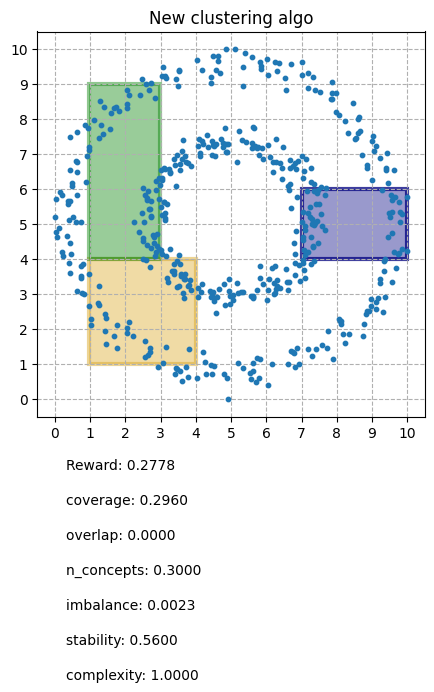

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))

vlib.init_axis(ax, f"New clustering algo", linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)), grid_params=dict(zorder=0, linestyle='--'))

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
vlib.draw_clustering(ax, best_clustering, concepts_df)

reward, reward_details = clib.clustering_reward2(best_clustering, concepts_df, **weight_params)
for i, (k, v) in enumerate([('Reward', reward)]+ list(reward_details.items())):
    ax.text(-1, linscale_y[0]-(i+2)*(linscale_y[1]-linscale_y[0]), f"{k}: {v:.4f}")


# ax.legend(loc='lower right')
#fig.savefig('../figures/pipe_step4_circlesdata.pdf')
plt.show()

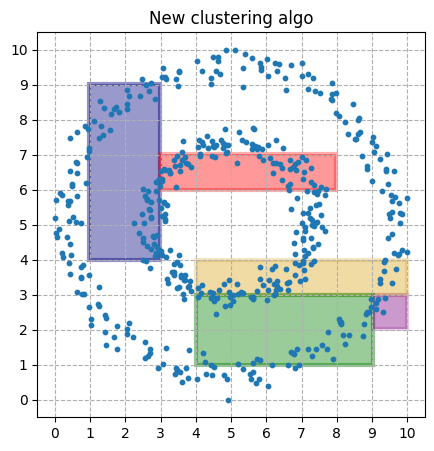

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))

vlib.init_axis(ax, f"New clustering algo", linscale_x, linscale_y, range(len(linscale_x)), range(len(linscale_y)), grid_params=dict(zorder=0, linestyle='--'))

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
vlib.draw_clustering(ax, [1,3,6,7,13], concepts_df)


# ax.legend(loc='lower right')
#fig.savefig('../figures/pipe_step4_circlesdata.pdf')
plt.show()